<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec5-Transfer_learning_CNN.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code

---
# Lecture notes - Transfer learning CNN
---

This is the lecture note for **transfer learning**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to transfer learning. I encourage you to read further about transfer learning. </p>

Read more:

- [Transfer learning wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)
- [Transfer learning on tf_flower - Nutan (2021) medium](https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc)
- [Know Your Data](https://knowyourdata-tfds.withgoogle.com/#dataset=tf_flowers&tab=DATASETS)
- [tf_flowers dataset - TensorFlow](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- [TensorSpec object - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/TensorSpec?version=nightly)
- [Image data preprocessing - TensorFlow](https://link)
- [transfer learning flower set- towardsdatascience](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [ImageNet](https://www.image-net.org/index.php)
- [Keras applications](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
- [Remove layers keras - stackoverflow](https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights)

---

## Flower dataset

In this lecture we'll move on to working with core tensorflow and their objects. Data will come from tensorflow_datasets

In [28]:
import tensorflow_datasets as tfds
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

plt.style.use("seaborn-white")

(train, test), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info= True
)

info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [29]:
label_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

img shape: (333, 500, 3), label: 2
img shape: (212, 320, 3), label: 3
img shape: (240, 320, 3), label: 3
img shape: (240, 320, 3), label: 4
img shape: (317, 500, 3), label: 3
img shape: (212, 320, 3), label: 0
img shape: (240, 240, 3), label: 0
img shape: (333, 500, 3), label: 0


2022-05-01 13:23:36.564201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


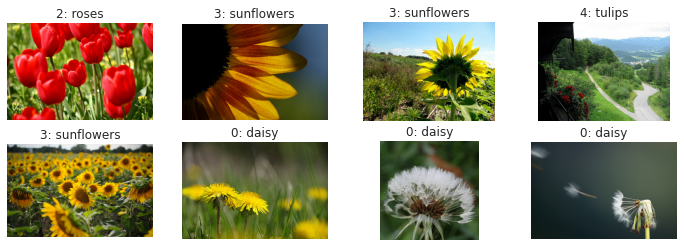

In [30]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
    print(f"img shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis("off")

---
## Preprocessing

- need to reshape the images
- scale them
- create batches 
- optimize performance utilizing CPU and GPU with prefetching a batch

In [31]:
def preprocess_images(img, label, img_shape = (120, 120)):
    img = tf.image.resize(img, img_shape)/255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

# prefetch always get one batch of data ready 
# GPu work on backpropagation and forward propagation while CPU works on preprocessing a batch
train_batch = train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1)
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)

test_batch

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int64)>

---
## Transfer learning

There a few approaches to transfer learning and the approach we're using in this lecture note is: 

1. Load a model which has been pretrained on a large dataset e.g. imagenet. 
2. Remove the top, i.e. the classifier part and MLP part
3. Freeze the layers weights of the pretrained network. Reason for this is to use the pretrained weights to extract feature maps from new images which it hasn't seen before. 
4. Add an MLP part and classifier part. Train the data on the last part. 

Idea behind this is that we can reuse a network that is trained on large dataset as many kernels such as edge detectors, simple shape detectors can be used on other datasets as well. Also this is cheap as it is more data-expensive and computationally expensive to train a large network from scratch.

However some deeper layers extract more and more complicated structures that may be too specific for another dataset. Then another approach is to use the shallower layers for feature extraction and train the new dataset on the deeper layers to fine-tune the network. Then add an MLP part as in above. 

In [46]:
from tensorflow.keras.applications import Xception

feature_extractor = Xception(weights = "imagenet", include_top = False, input_shape = (input_shape))
feature_extractor.summary()


83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 59, 59, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 59, 59, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 59, 59, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential(
    [
        feature_extractor,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ]
)

for layer in feature_extractor.layers:
    layer.trainable = False
    
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1285      
Total params: 21,387,309
Trainable params: 525,829
Non-trainable params: 20,861,480
____________________________________

In [48]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
92/92 [==============================] - 6s 44ms/step - loss: 0.9825 - acc: 0.6281 - val_loss: 0.5720 - val_acc: 0.7984
Epoch 2/20
92/92 [==============================] - 3s 35ms/step - loss: 0.6708 - acc: 0.7595 - val_loss: 0.5201 - val_acc: 0.8079
Epoch 3/20
92/92 [==============================] - 3s 34ms/step - loss: 0.5911 - acc: 0.7888 - val_loss: 0.4901 - val_acc: 0.8324
Epoch 4/20
92/92 [==============================] - 3s 36ms/step - loss: 0.5209 - acc: 0.8042 - val_loss: 0.4834 - val_acc: 0.8270
Epoch 5/20
92/92 [==============================] - 3s 35ms/step - loss: 0.4744 - acc: 0.8243 - val_loss: 0.4677 - val_acc: 0.8420
Epoch 6/20
92/92 [==============================] - 3s 34ms/step - loss: 0.4467 - acc: 0.8406 - val_loss: 0.4503 - val_acc: 0.8447
Epoch 7/20
92/92 [==============================] - 3s 35ms/step - loss: 0.4267 - acc: 0.8535 - val_loss: 0.4380 - val_acc: 0.8529
Epoch 8/20
92/92 [==============================] - 3s 34ms/step - loss: 0.3773 - a

In [49]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.982514,0.628065,0.571973,0.798365
1,0.670843,0.759537,0.520126,0.807902
2,0.591053,0.788828,0.490112,0.832425
3,0.520855,0.804155,0.483374,0.826975
4,0.474357,0.824251,0.467715,0.841962


<AxesSubplot:>

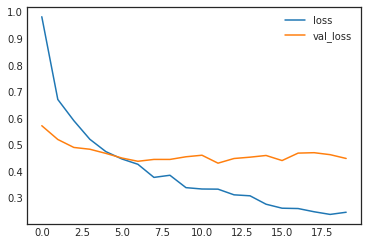

In [50]:
metrics[["loss", "val_loss"]].plot()

<AxesSubplot:>

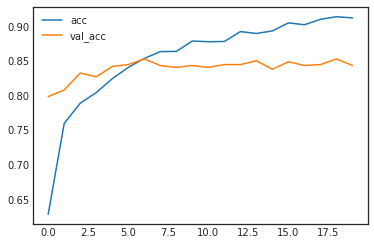

In [51]:
metrics[["acc", "val_acc"]].plot()

---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---
